In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PyEMD import EMD,CEEMDAN
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import normalize,StandardScaler,MinMaxScaler
from tensorflow.keras.layers import Dense,Bidirectional,LSTM,BatchNormalization,Dropout,Lambda,Conv1D


In [2]:
df=pd.read_csv("Downloads/esg.csv")
df['Date']=pd.to_datetime(df['Date'])
df=df[['Date','China']]
series=df['China'].to_numpy()

/var/folders/t5/7x9ckhzd32b0xngsxj0lpng40000gn/T/ipykernel_60102/603831061.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date']=pd.to_datetime(df['Date'])


In [3]:
df

,Date,China
0,2015-02-01,1.385
1,2015-03-01,1.033
2,2015-04-01,6.696
3,2015-05-01,-1.726
4,2015-06-01,-3.192
...,...,...
90,2022-08-01,0.060
91,2022-09-01,-6.917
92,2022-10-01,-8.008
93,2022-11-01,11.262


In [4]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


In [5]:
#DECOMPOSING OUR SERIES SIGNAL FOR TRAINING
emd=EMD()
imfs=emd.emd(series)

In [6]:
type(series)

numpy.ndarray

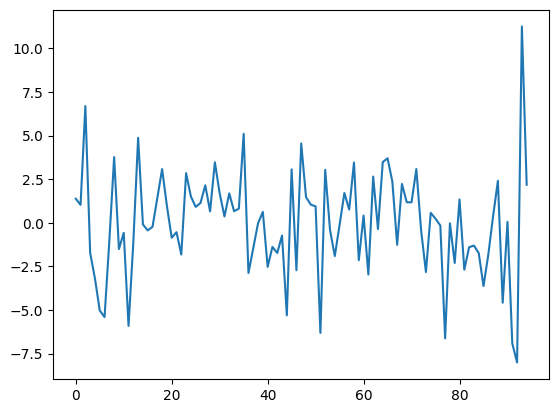

In [7]:
plt.plot(series)

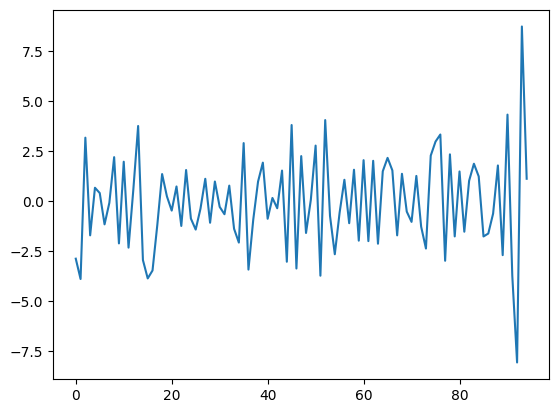

In [8]:
imfs.shape
plt.plot(imfs[0])


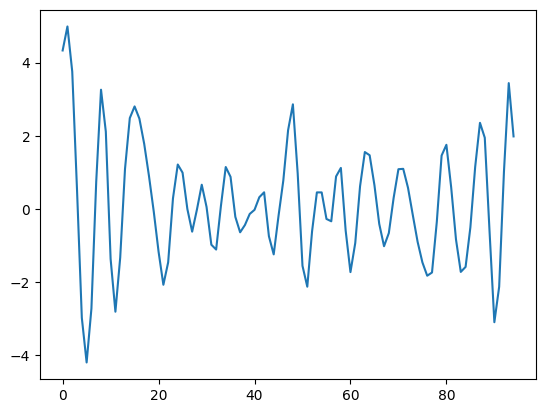

In [9]:
plt.plot(imfs[1])



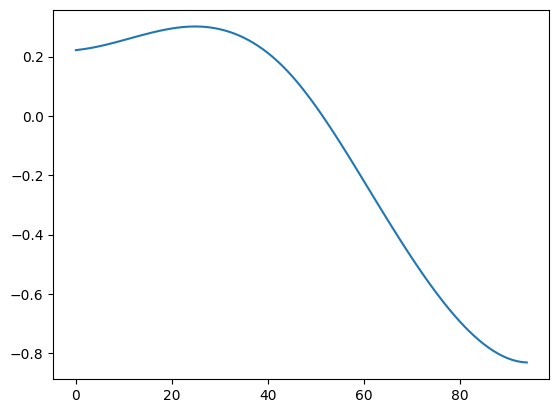

In [10]:
plt.plot(imfs[4])

In [11]:
#split the dataset into train and val(60/40% split)
time=np.arange(95)
X_train=imfs[:, :57]
#X_train=X_train.reshape((-1,1))
time_train=time[:57]
X_val=imfs[:,57:]
#X_val=X_val.reshape((-1,1))
time_val=time[57:]
#normalise inputs between 0 and 1
#scaler=MinMaxScaler(feature_range=(0,1))
#X_train=scaler.fit_transform(X_train)


In [12]:
X_val.shape

(5, 38)

In [13]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffler):
    #transform series to tf dataset
    dataset=tf.data.Dataset.from_tensor_slices(series)
    #window the dataset
    dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
    #flatten the window by putting its elements as single batch
    dataset=dataset.flat_map(lambda window:window.batch(window_size+1))
    #create tuples of features and labels
    dataset=dataset.map(lambda window:(window[:-1],window[-1]))
    #shuffle windows
    dataset=dataset.shuffle(shuffle_buffler,seed=42)
    #create batches of windows
    dataset=dataset.batch(batch_size).prefetch(1)
    
    return dataset

def forecast_series(model,series,window_size,batch_size):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size,shift=1,drop_remainder=True)
    dataset=dataset.flat_map(lambda w:w.batch(window_size))
    dataset=dataset.batch(batch_size).prefetch(1)
    forecast=model.predict(dataset)
    
    return forecast   
    

In [14]:
#window size , batch size and shuffle 
window_size=5
batch_size=4
shuffle_buffler=95
learning_rate=0.01
n_epoch=500

In [15]:
datasets=windowed_dataset(series,window_size,batch_size,shuffle_buffler)

In [16]:
for x,y in datasets:
    print(x)
    print(y)

tf.Tensor(
[[-0.435 -0.227  1.422  3.082  0.969]
 [ 3.082  0.969 -0.854 -0.534 -1.816]
 [-1.826  0.379  2.412 -4.582  0.06 ]
 [-1.26   2.231  1.181  1.178  3.085]], shape=(4, 5), dtype=float64)
tf.Tensor([-0.854  2.852 -6.917 -0.455], shape=(4,), dtype=float64)
tf.Tensor(
[[ 2.152  0.658  3.473  1.688  0.364]
 [ 3.486  3.703  2.363 -1.26   2.231]
 [-0.021  0.627 -2.523 -1.379 -1.728]
 [ 3.768 -1.503 -0.572 -5.909 -1.116]], shape=(4, 5), dtype=float64)
tf.Tensor([ 1.689  1.181 -0.729  4.882], shape=(4,), dtype=float64)
tf.Tensor(
[[-1.903 -0.109  1.711  0.762  3.459]
 [ 0.627 -2.523 -1.379 -1.728 -0.729]
 [ 1.14   2.152  0.658  3.473  1.688]
 [-2.965  2.653 -0.355  3.486  3.703]], shape=(4, 5), dtype=float64)
tf.Tensor([-2.146 -5.305  0.364  2.363], shape=(4,), dtype=float64)
tf.Tensor(
[[-2.302  1.34  -2.687 -1.398 -1.302]
 [-0.729 -5.305  3.067 -2.717  4.553]
 [-0.109  1.711  0.762  3.459 -2.146]
 [ 2.412 -4.582  0.06  -6.917 -8.008]], shape=(4, 5), dtype=float64)
tf.Tensor([-1.728  1

In [17]:
datasets=[]
for i in range(0,len(X_train)):
    datasets.append(windowed_dataset(X_train[i],window_size,batch_size,shuffle_buffler))


In [18]:
#WE WILL TRAIN OUR MODEL ON DECOMPOSED IMFS 
tf.keras.backend.clear_session()
model1=tf.keras.models.Sequential([
    Conv1D(filters=32,kernel_size=3,strides=1,padding='causal',activation='relu',input_shape=[window_size,1]),
    Dropout(0.1),
    Bidirectional(LSTM(20,return_sequences=True)), 
    Dropout(0.2),
    Bidirectional(LSTM(20,return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(20)),
    Dropout(0.4),
    Dense(1)
    ])
learning_rate=0.001
n_epoch=500
model1.compile(loss=tf.keras.losses.MeanAbsoluteError(),optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),metrics=['mae'])
history1=model1.fit(datasets[0],epochs=n_epoch)

Epoch 1/500
13/13 [==============================] - 3s 27ms/step - loss: 1.6438 - mae: 1.6438
Epoch 2/500
13/13 [==============================] - 0s 4ms/step - loss: 1.6280 - mae: 1.6280
Epoch 3/500
13/13 [==============================] - 0s 3ms/step - loss: 1.6188 - mae: 1.6188
Epoch 4/500
13/13 [==============================] - 0s 3ms/step - loss: 1.6042 - mae: 1.6042
Epoch 5/500
13/13 [==============================] - 0s 4ms/step - loss: 1.6102 - mae: 1.6102
Epoch 6/500
13/13 [==============================] - 0s 3ms/step - loss: 1.6039 - mae: 1.6039
Epoch 7/500
13/13 [==============================] - 0s 3ms/step - loss: 1.6144 - mae: 1.6144
Epoch 8/500
13/13 [==============================] - 0s 3ms/step - loss: 1.5572 - mae: 1.5572
Epoch 9/500
13/13 [==============================] - 0s 3ms/step - loss: 1.5651 - mae: 1.5651
Epoch 10/500
13/13 [==============================] - 0s 3ms/step - loss: 1.5180 - mae: 1.5180
Epoch 11/500
13/13 [==============================] - 0s 4

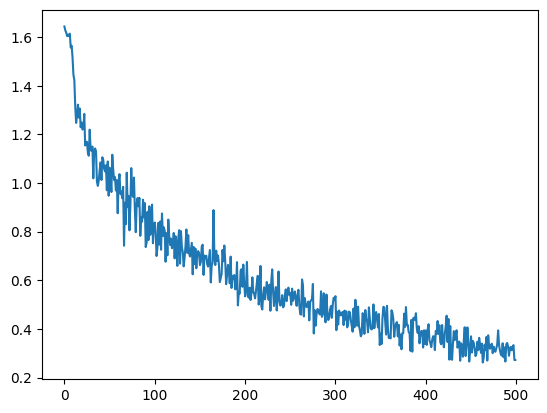

In [19]:
epochs=np.arange(n_epoch)
loss1=history1.history['loss']
plt.plot(epochs,loss1)

In [20]:
    tf.keras.backend.clear_session()
    model2=tf.keras.models.Sequential([
    Conv1D(filters=32,kernel_size=3,strides=1,padding='causal',activation='relu',input_shape=[window_size,1]),
    Dropout(0.1),
    Bidirectional(LSTM(20,return_sequences=True)), 
    Dropout(0.2),
    Bidirectional(LSTM(20,return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(20)),
    Dropout(0.4),
    Dense(1)

    ])
    learning_rate=0.001
    n_epoch=500
    model2.compile(loss=tf.keras.losses.MeanAbsoluteError(),optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),metrics=['mae'])
    history2=model2.fit(datasets[1],epochs=n_epoch)

Epoch 1/500
13/13 [==============================] - 3s 6ms/step - loss: 1.1423 - mae: 1.1423
Epoch 2/500
13/13 [==============================] - 0s 3ms/step - loss: 1.1141 - mae: 1.1141
Epoch 3/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0898 - mae: 1.0898
Epoch 4/500
13/13 [==============================] - 0s 3ms/step - loss: 1.0112 - mae: 1.0112
Epoch 5/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9517 - mae: 0.9517
Epoch 6/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9403 - mae: 0.9403
Epoch 7/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9426 - mae: 0.9426
Epoch 8/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9038 - mae: 0.9038
Epoch 9/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9281 - mae: 0.9281
Epoch 10/500
13/13 [==============================] - 0s 3ms/step - loss: 0.9048 - mae: 0.9048
Epoch 11/500
13/13 [==============================] - 0s 3m

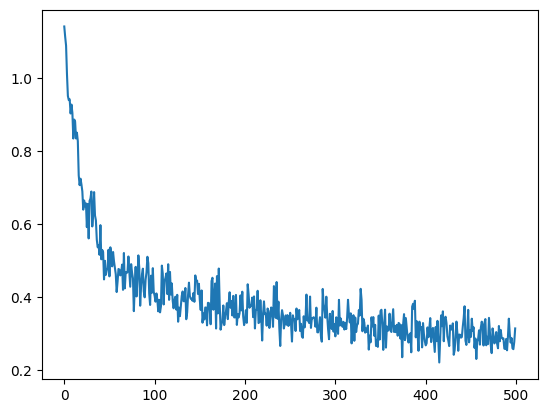

In [21]:
epochs=np.arange(n_epoch)
loss2=history2.history['loss']
plt.plot(epochs,loss2)

In [ ]:
    tf.keras.backend.clear_session()
    model3=tf.keras.models.Sequential([
    Conv1D(filters=32,kernel_size=3,strides=1,padding='causal',activation='relu',input_shape=[window_size,1]),
    Dropout(0.1),
    Bidirectional(LSTM(20,return_sequences=True)), 
    Dropout(0.2),
    Bidirectional(LSTM(20,return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(20)),
    Dropout(0.4),
    Dense(1)

    ])
    learning_rate=0.001
    n_epoch=500
    model3.compile(loss=tf.keras.losses.MeanAbsoluteError(),optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),metrics=['mae'])
    history3=model3.fit(datasets[2],epochs=n_epoch)

Epoch 1/500
13/13 [==============================] - 3s 5ms/step - loss: 0.4969 - mae: 0.4969
Epoch 2/500
13/13 [==============================] - 0s 3ms/step - loss: 0.4869 - mae: 0.4869
Epoch 3/500
13/13 [==============================] - 0s 3ms/step - loss: 0.4787 - mae: 0.4787
Epoch 4/500
13/13 [==============================] - 0s 3ms/step - loss: 0.4414 - mae: 0.4414
Epoch 5/500
13/13 [==============================] - 0s 3ms/step - loss: 0.3716 - mae: 0.3716
Epoch 6/500
13/13 [==============================] - 0s 4ms/step - loss: 0.2473 - mae: 0.2473
Epoch 7/500
13/13 [==============================] - 0s 4ms/step - loss: 0.2214 - mae: 0.2214
Epoch 8/500
13/13 [==============================] - 0s 4ms/step - loss: 0.1966 - mae: 0.1966
Epoch 9/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1881 - mae: 0.1881
Epoch 10/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2503 - mae: 0.2503
Epoch 11/500
13/13 [==============================] - 0s 3m

In [ ]:
epochs=np.arange(n_epoch)
loss3=history3.history['loss']
plt.plot(epochs,loss3)

In [ ]:
    tf.keras.backend.clear_session()
    model4=tf.keras.models.Sequential([
    Conv1D(filters=32,kernel_size=3,strides=1,padding='causal',activation='relu',input_shape=[window_size,1]),
    Dropout(0.1),
    Bidirectional(LSTM(20,return_sequences=True)), 
    Dropout(0.2),
    Bidirectional(LSTM(20,return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(20)),
    Dropout(0.4),
    Dense(1)

    ])
    learning_rate4=0.001
    n_epoch4=500
    model4.compile(loss=tf.keras.losses.MeanAbsoluteError(),optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate4),metrics=['mae'])
    history4=model4.fit(datasets[3],epochs=n_epoch4)

In [ ]:
epochs=np.arange(n_epoch4)
loss4=history4.history['loss']
plt.plot(epochs,loss4)

In [ ]:
    tf.keras.backend.clear_session()
    model5=tf.keras.models.Sequential([
    Conv1D(filters=32,kernel_size=3,strides=1,padding='causal',activation='relu',input_shape=[window_size,1]),
    Dropout(0.1),
    Bidirectional(LSTM(20,return_sequences=True)), 
    Dropout(0.2),
    Bidirectional(LSTM(20,return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(20)),
    Dropout(0.4),
    Dense(1)

    ])
    learning_rate=0.001
    n_epoch=500
    model5.compile(loss=tf.keras.losses.MeanAbsoluteError(),optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),metrics=['mae'])
    history5=model5.fit(datasets[4],epochs=n_epoch)

In [ ]:
epochs=np.arange(n_epoch)
loss5=history5.history['loss']
plt.plot(epochs,loss5)

In [ ]:
loss=loss1[-1]+loss2[-1]+loss3[-1]+loss4[-1]+loss5[-1]
loss

In [ ]:
imf_val=imfs[:,57-window_size:-1]
imf_val.shape

In [43]:
imf_val=imf_val.reshape((imf_val.shape[0],imf_val.shape[1],1))
models=[model1,model2,model3,model4,model5]
history=[history1,history2,history3,history4,history5]

In [44]:
for model in models:
    print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             128       
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 bidirectional (Bidirection  (None, 5, 40)             8480      
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 40)             0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 5, 40)             9760      
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 5, 40)             0

In [45]:
fore=[]
for i in range(0,len(imf_val)):
    fore.append(forecast_series(models[i],imf_val[i],window_size,batch_size))


10/10 [==============================] - 1s 2ms/step


In [46]:
np.shape(fore)

(5, 38, 1)

In [47]:
fore=np.squeeze(fore)

In [48]:
f=fore[0]+fore[1]+fore[2]+fore[3]+fore[4]
f.shape

(38,)

In [49]:
series[57:].shape
loss=tf.keras.losses.MeanAbsoluteError()


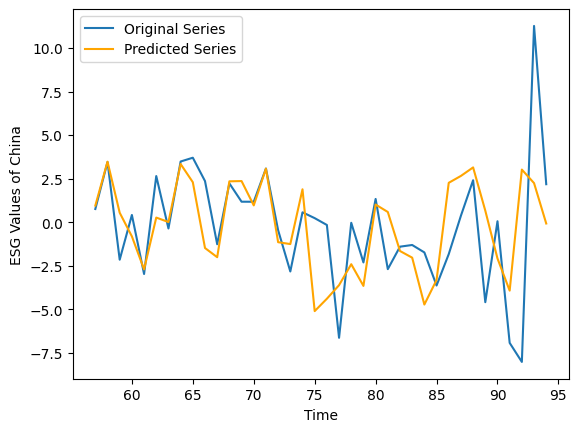

2.1670911

In [50]:
plt.plot(time_val,series[57: ],label='Original Series')
plt.plot(time_val,f,label='Predicted Series',color='orange')
plt.xlabel('Time')
plt.ylabel('ESG Values'+' of China')
plt.legend()
plt.show()
loss(series[57:],f).numpy()

In [51]:
#PREDICT FUTURE VALUES
fut_set=imfs[:,95-window_size:]

In [52]:
fut_set.shape

(5, 5)

In [53]:
fut_set=fut_set.reshape(fut_set.shape[0],fut_set.shape[1],1)

In [54]:
a1=fut_set[0]
a2=fut_set[1]
a3=fut_set[2]
a4=fut_set[3]
a5=fut_set[4]


In [55]:
hf=df['China'].to_numpy()


In [56]:
#fut_ser =np.array([[]])

#predict_future(500,a1,fut_ser,models[i])
#predict_future(500,a2,fut_ser,models[i])
#predict_future(500,a3,fut_ser,models[i])
#predict_future(500,a4,fut_ser,models[i])
#predict_future(500,a5,fut_ser,models[i])

In [57]:
pred1=np.array([])
pred1=pred1.reshape((-1,1))
    
for j in range(1,1826):
        pred1=np.concatenate([pred1,forecast_series(model1,a1,window_size,batch_size)])
        a1=np.concatenate([a1,pred1])
        a1=a1[j:]
        
pred1=np.flip(pred1)

    

1/1 [==============================] - 0s 14ms/step


In [58]:
pred2=np.array([])
pred2=pred2.reshape((-1,1))
    
for j in range(1,1826):
        pred2=np.concatenate([pred2,forecast_series(model2,a2,window_size,batch_size)])
        a2=np.concatenate([a2,pred2])
        a2=a2[j:]
        
pred2=np.flip(pred2)


1/1 [==============================] - 0s 14ms/step


In [59]:
pred3=np.array([])
pred3=pred3.reshape((-1,1))
    
for j in range(1,1826):
        pred3=np.concatenate([pred3,forecast_series(model3,a3,window_size,batch_size)])
        a3=np.concatenate([a3,pred3])
        a3=a3[j:]
        
pred3=np.flip(pred3)


1/1 [==============================] - 0s 31ms/step


In [60]:
pred4=np.array([])
pred4=pred4.reshape((-1,1))
    
for j in range(1,1826):
        pred4=np.concatenate([pred4,forecast_series(model4,a4,window_size,batch_size)])
        a4=np.concatenate([a4,pred4])
        a4=a4[j:]
        
pred4=np.flip(pred4)


1/1 [==============================] - 0s 13ms/step


In [61]:
pred5=np.array([])
pred5=pred5.reshape((-1,1))
    
for j in range(1,1826):
        pred5=np.concatenate([pred5,forecast_series(model5,a5,window_size,batch_size)])
        a5=np.concatenate([a5,pred5])
        a5=a5[j:]
        
pred5=np.flip(pred5)


1/1 [==============================] - 0s 13ms/step


In [62]:
pred=pred1+pred2+pred3+pred4+pred5

In [63]:
pred.shape
pred=np.squeeze(pred)

In [64]:
pred.shape

(1825,)

In [65]:
hf=np.concatenate([hf,pred])


In [73]:
plt.figure(figsize=(1000,50))
plt.plot(hf,label='Original Series')
plt.plot(np.arange(95,1920),pred,label='Predicted Values',color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('ESG Values')
plt.show()

ValueError: Image size of 100000x5000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 100000x5000 with 1 Axes>

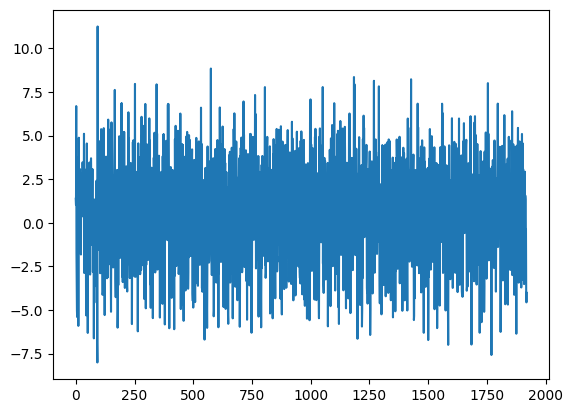

In [72]:
plt.plot(np.arange(len(hf)),hf)

VALIDATING ON HONG KONG 

In [95]:
hk=pd.read_csv('Downloads/esg.csv')
hong=hk[['Hong-Kong']]
indo=hk[['Indonesia']]
japan=hk[['Japan']]
south=hk[['South_Korea']]
malay=hk[['Malaysia']]
thai=hk[['Thailand']]
vietn=hk[['Vietnam']]

In [96]:
five_imf_countries=[hong,indo,japan,south,malay,thai,vietn]

In [97]:
hong.shape

(95, 1)

In [98]:
for i in range(len(five_imf_countries)):
    five_imf_countries[i]=np.squeeze(five_imf_countries[i].to_numpy())

In [99]:
hong=five_imf_countries[0]
indo=five_imf_countries[1]
japan=five_imf_countries[2]
south=five_imf_countries[3]
malay=five_imf_countries[4]
thai=five_imf_countries[5]
vietn=five_imf_countries[6]

In [112]:
hong.shape

(95,)

In [113]:
imfs_hong=emd.emd(hong)
imfs_indo=emd.emd(indo)
imfs_japan=emd.emd(japan)
imfs_south=emd.emd(south)
imfs_malay=emd.emd(malay)
imfs_thai=emd.emd(thai)
imfs_vietn=emd.emd(vietn)

In [114]:
np.shape(imfs_hong)

(6, 95)

In [115]:
indo_val=imfs_indo[:,57:]
indo_val_set=imfs_indo[:,57-window_size:-1]

In [58]:
indo_val_set=indo_val_set.reshape((indo_val_set.shape[0],indo_val_set.shape[1],1))

indo_fore=[]
for i in range(0,len(indo_val_set)):
    indo_fore.append(forecast_series(models[i],indo_val_set[i],window_size,batch_size))


NameError: name 'indo_val_set' is not defined

In [521]:
print(np.shape(indo_fore))
indo_fore=np.squeeze(indo_fore)
indo_f=indo_fore[0]+indo_fore[1]+indo_fore[2]+indo_fore[3]+indo_fore[4]
print(indo_f.shape)

(5, 38, 1)
(38,)


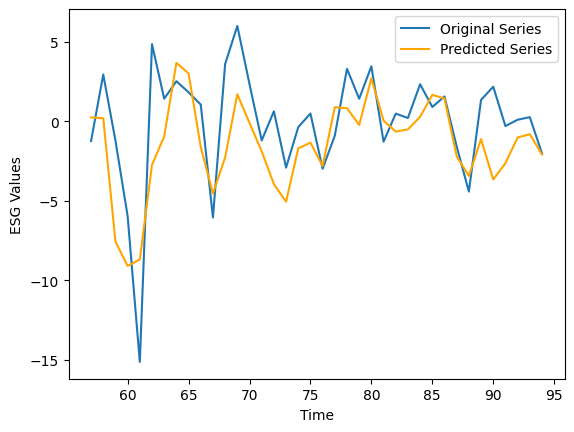

2.3728414

In [522]:
plt.plot(time_val,indo[57: ],label='Original Series')
plt.plot(time_val,indo_f,label='Predicted Series',color='orange')
plt.xlabel('Time')
plt.ylabel('ESG Values')
plt.legend()
plt.show()
loss(indo[57:],indo_fore).numpy()

In [70]:
def predict_plot_val(models,imf_val,X_val,window_size,batch_size,time_val,country):
    imf_val=imf_val.reshape((imf_val.shape[0],imf_val.shape[1],1))

    fore=[]
    for i in range(0,len(imf_val)):
            fore.append(forecast_series(models[i],imf_val[i],window_size,batch_size))
    
    fore=np.squeeze(fore)
    f=fore[0]+fore[1]+fore[2]+fore[3]+fore[4]
        
    plt.plot(time_val,X_val,label='Original Series')
    plt.plot(time_val,f,label='Predicted Series',color='orange')
    plt.xlabel('Time')
    plt.ylabel('ESG Values'+ country)
    plt.legend()
    plt.show()
    print("Final Valdiation Loss:",loss(X_val,f).numpy())
    

10/10 [==============================] - 0s 1ms/step


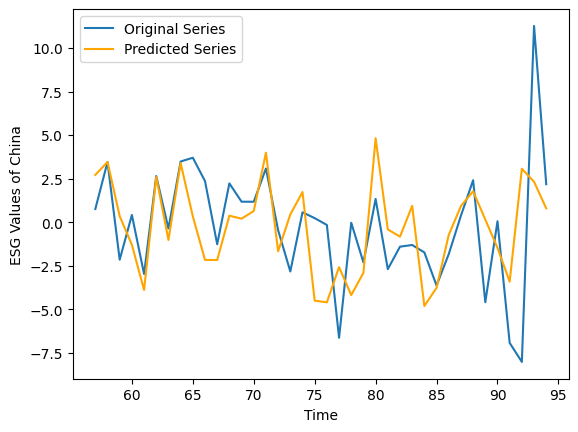

Final Valdiation Loss: 2.3623176


In [72]:
predict_plot_val(models,imf_val,series[57: ],window_size,batch_size,time_val,' of China')

In [710]:
def five_imfs_training_model(X_train,window_size,batch_size,shuffle_buffler,n_epoch=500,learning_rate=0.001):
    datasets=[]
    for i in range(0,len(X_train)):
         datasets.append(windowed_dataset(X_train[i],window_size,batch_size,shuffle_buffler))
    loss=0
    for j in range(0,len(models)):
        tf.keras.backend.clear_session()
        models[j].compile(loss=tf.keras.losses.MeanAbsoluteError(),optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),metrics=['mae'])
        history[j]=models[j].fit(datasets[j],epochs=n_epoch)
        plt.plot(np.arange(n_epoch),history[j].history['loss'])
        loss+=history[j].history['loss'][-1]
        plt.show()
        
    print("Final Training Loss:",loss)     

Epoch 1/500
13/13 [==============================] - 3s 6ms/step - loss: 0.2174 - mae: 0.2174
Epoch 2/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2349 - mae: 0.2349
Epoch 3/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2175 - mae: 0.2175
Epoch 4/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2604 - mae: 0.2604
Epoch 5/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2326 - mae: 0.2326
Epoch 6/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2661 - mae: 0.2661
Epoch 7/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2271 - mae: 0.2271
Epoch 8/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2058 - mae: 0.2058
Epoch 9/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2618 - mae: 0.2618
Epoch 10/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2808 - mae: 0.2808
Epoch 11/500
13/13 [==============================] - 0s 3m

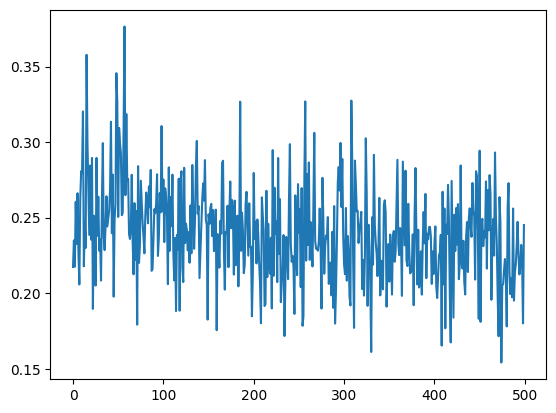

Epoch 1/500
13/13 [==============================] - 3s 5ms/step - loss: 0.2295 - mae: 0.2295
Epoch 2/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2309 - mae: 0.2309
Epoch 3/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2144 - mae: 0.2144
Epoch 4/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2233 - mae: 0.2233
Epoch 5/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2343 - mae: 0.2343
Epoch 6/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2119 - mae: 0.2119
Epoch 7/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2323 - mae: 0.2323
Epoch 8/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1752 - mae: 0.1752
Epoch 9/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2127 - mae: 0.2127
Epoch 10/500
13/13 [==============================] - 0s 3ms/step - loss: 0.2086 - mae: 0.2086
Epoch 11/500
13/13 [==============================] - 0s 3m

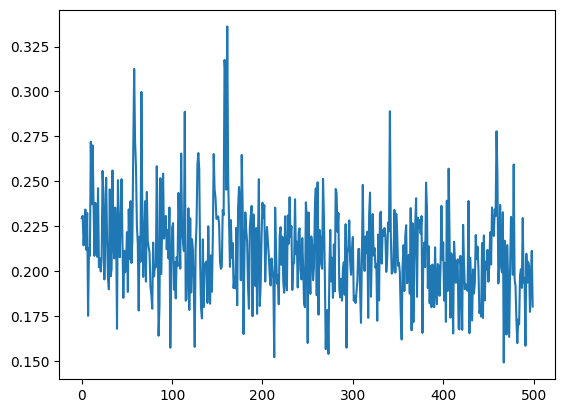

Epoch 1/500
13/13 [==============================] - 3s 8ms/step - loss: 0.0874 - mae: 0.0874
Epoch 2/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1028 - mae: 0.1028
Epoch 3/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0806 - mae: 0.0806
Epoch 4/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0828 - mae: 0.0828
Epoch 5/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0698 - mae: 0.0698
Epoch 6/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0715 - mae: 0.0715
Epoch 7/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0816 - mae: 0.0816
Epoch 8/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0777 - mae: 0.0777
Epoch 9/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0762 - mae: 0.0762
Epoch 10/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0937 - mae: 0.0937
Epoch 11/500
13/13 [==============================] - 0s 3m

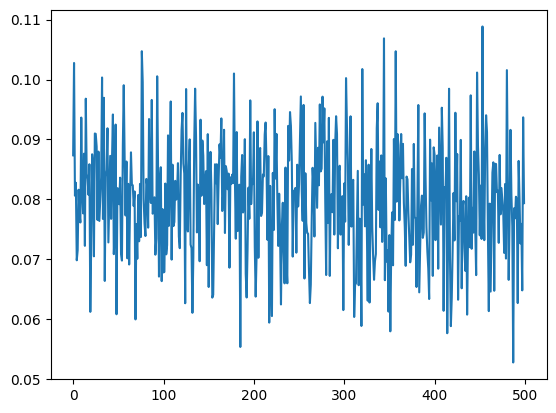

Epoch 1/500
13/13 [==============================] - 8s 8ms/step - loss: 0.1072 - mae: 0.1072
Epoch 2/500
13/13 [==============================] - 0s 4ms/step - loss: 0.0912 - mae: 0.0912
Epoch 3/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0859 - mae: 0.0859
Epoch 4/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0935 - mae: 0.0935
Epoch 5/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0865 - mae: 0.0865
Epoch 6/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0883 - mae: 0.0883
Epoch 7/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1098 - mae: 0.1098
Epoch 8/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0989 - mae: 0.0989
Epoch 9/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0901 - mae: 0.0901
Epoch 10/500
13/13 [==============================] - 0s 3ms/step - loss: 0.1010 - mae: 0.1010
Epoch 11/500
13/13 [==============================] - 0s 3m

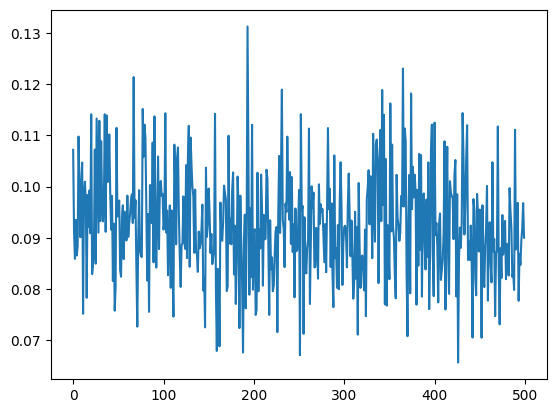

Epoch 1/500
13/13 [==============================] - 3s 5ms/step - loss: 0.0126 - mae: 0.0126
Epoch 2/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0136 - mae: 0.0136
Epoch 3/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0098 - mae: 0.0098
Epoch 4/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0114 - mae: 0.0114
Epoch 5/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0121 - mae: 0.0121
Epoch 6/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0103 - mae: 0.0103
Epoch 7/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0087 - mae: 0.0087
Epoch 8/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0094 - mae: 0.0094
Epoch 9/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0123 - mae: 0.0123
Epoch 10/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0119 - mae: 0.0119
Epoch 11/500
13/13 [==============================] - 0s 3m

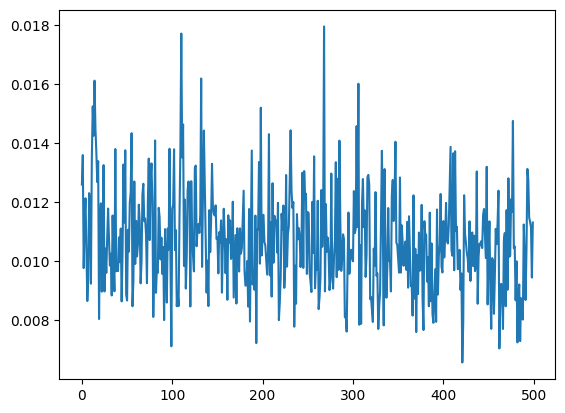

Final Training Loss: 0.6061143865808845
10/10 [==============================] - 1s 2ms/step


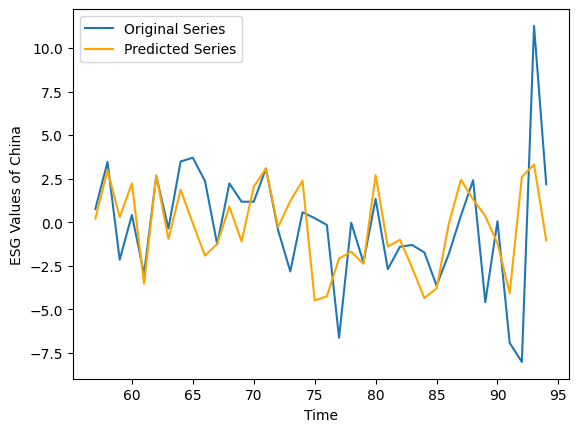

Final Valdiation Loss: 2.2278917


In [711]:
five_imfs_training_model(imfs[:,:57],window_size,batch_size,shuffle_buffler)
predict_plot_val(models,imf_val,series[57:],window_size,batch_size,time_val,' of China')